In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [1]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import class_weight
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from chembench import load_data, dataset
warnings.filterwarnings("ignore")
from deepchem.molnet import load_clintox, load_tox21, load_bace_classification, load_bbbp
import pandas as pd
from simcse import SimCSE
from tqdm import tqdm
import numpy as np

2022-09-04 21:11:39.582234: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-04 21:11:39.630274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-04 21:11:39.630285: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
clintox_tasks, clintox_datasets, transformers = load_tox21()
(train_dataset, valid_dataset, test_dataset) = clintox_datasets
clintox_datasets

08/29/2022 11:06:02 - INFO - deepchem.data.datasets -   Loading dataset from disk.
08/29/2022 11:06:02 - INFO - deepchem.data.datasets -   Loading dataset from disk.
08/29/2022 11:06:02 - INFO - deepchem.data.datasets -   Loading dataset from disk.


(<DiskDataset X.shape: (6264, 1024), y.shape: (6264, 12), w.shape: (6264, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>,
 <DiskDataset X.shape: (783, 1024), y.shape: (783, 12), w.shape: (783, 12), ids: ['N#C[C@@H]1CC(F)(F)CN1C(=O)CNC1CC2CCC(C1)N2c1ncccn1'
  'CN(C)C(=O)NC1(c2ccccc2)CCN(CCC[C@@]2(c3ccc(Cl)c(Cl)c3)CCCN(C(=O)c3ccccc3)C2)CC1'
  'CSc1nnc(C(C)(C)C)c(=O)n1N' ...
  'O=C(O[C@H]1CN2CCC1CC2)N1CCc2ccccc2[C@@H]1c1ccccc1'
  'C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4[C@H]3C(=C)C[C@@]21CC'
  'NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CCN(CCc2ccc3c(c2)CCO3)C1'], task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>,
 <DiskDataset X.shape: (784, 1024), y.shape: (784, 12), w.shape: (784, 12), ids: ['CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O.CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O.c1ccc(CNCCNCc2ccccc2)cc1'
  'CC(C)(c1ccc(Oc2ccc3c(c2)C(=O)OC3=O)cc1)c1ccc(Oc2ccc3c(c2)C(=O)OC3=O)cc1'
  'Cc1cc(C(C)(C)C)c(O)c(C)c1

In [5]:
def featurize_smiles_simcse_bert(encoder, smiles):
    featurized_smiles = []
    for smile in (smiles):
        featurized_smiles.append(encoder.encode(smile).tolist())
    return np.array(featurized_smiles)

In [6]:
from pathlib import Path
basemodel = '/home/shahrukh/SimCSE/result/'


0.9 /home/shahrukh/SimCSE/result/tox21-simcse-smole-bert-mlm-9
0.7 /home/shahrukh/SimCSE/result/tox21-simcse-smole-bert-mlm-7


In [7]:
res=[]
#for path in Path(basemodel).rglob('tox21*mlm*'):
for path in list(Path(basemodel).rglob('tox21*mlm-9'))+list(Path(basemodel).rglob('tox21*mlm-7')):
    encoder = SimCSE(str(path))
    mlmweight = round(int(str(path).split("-")[-1])*.1,2)
    train_X = featurize_smiles_simcse_bert(encoder,train_dataset.ids)#df.iloc[train_idx]['smiles'].values
    val_X = featurize_smiles_simcse_bert(encoder,valid_dataset.ids)#df.iloc[valid_idx]['smiles'].values
    test_X = featurize_smiles_simcse_bert(encoder,test_dataset.ids)#df.iloc[test_idx]['smiles'].values
    y_train, y_valid, y_test =train_dataset.y, valid_dataset.y,test_dataset.y
    parameters = {'estimator__class_weight':['balanced'],
              'estimator__kernel':['rbf','sigmoid'], 
              'estimator__C':[1,0.5,0.25], 'estimator__gamma':['auto','scale']}
    tox21_svc = GridSearchCV(OneVsRestClassifier(SVC(probability=True,
                                                     random_state=23)), 
                             parameters, cv=3, scoring='roc_auc',n_jobs=-1)
    
    result = tox21_svc.fit(train_X, y_train)
    pred = tox21_svc.predict_proba(val_X)
    print(f"Valid accuracy mlm {mlmweight}",roc_auc_score(y_valid,pred))
    pred = tox21_svc.predict_proba(test_X)
    roc_auc_score(y_test,pred)
    res.append({
        f"mlmweight-{mlmweight}": roc_auc_score(y_test,pred)
    })


Some weights of BertModel were not initialized from the model checkpoint at /home/shahrukh/SimCSE/result/tox21-simcse-smole-bert-mlm-9 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 205.28it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 182.06it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.44it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.11it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 201.43it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 186.17it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 127.35it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.96it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 168.53it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 201.82it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 175.56it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 191.07it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.51it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.73it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 202.49it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 212.42it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 208.15it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 183.15it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 202.56it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 201.35it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 209.35it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 109.15it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.25it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 204.87it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 155.55it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 208.85it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 173.23it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 171.20it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 189.75it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.45it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 209.23it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 205.08it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 210.23it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.93it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 205.51it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 194.81it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 187.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.36it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 121.15it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 151.52it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.87it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 86.17it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.12it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 136.87it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.37it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.78it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 81.33it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 191.88it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.21it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 103.12it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 89.12it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 95.23it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.27it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 158.81it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.92it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 197.89it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 92.12it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 135.93it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 185.74it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Some weights of BertModel were not initialized from the model checkpoint at /home/shahrukh/SimCSE/result/tox21-simcse-smole-bert-mlm-7 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 171.25it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 208.92it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 201.10it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 186.01it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 172.80it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 207.17it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 164.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.56it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 189.39it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 186.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 197.01it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 113.19it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 187.54it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.25it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 189.86it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 191.95it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 118.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 160.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 126.16it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 132.66it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.11it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 190.69it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 161.29it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 173.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 201.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 194.21it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 185.19it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 193.08it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 176.89it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 208.62it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 205.71it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 101.85it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 183.28it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 170.38it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 145.80it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 129.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 196.78it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 185.40it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 192.50it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 134.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.22it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 197.50it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 205.23it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 192.59it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 183.43it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 190.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.90it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 188.47it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.64it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.20it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 169.36it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.57it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 176.19it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 160.03it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 192.13it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 195.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 149.06it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.79it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [8]:
ress = {}
for idx, row in pd.DataFrame(res).iterrows():
    ress[float(pd.DataFrame(res).columns[idx].split("-")[1])]=row.iloc[idx]
df = pd.DataFrame([ress])

In [14]:
df.to_csv("tox21-mlm-benchmark.csv", index=False)

In [15]:
pd.read_csv("tox21-mlm-benchmark.csv")

0.1       0.2       0.3       0.4       0.5       0.6       0.8  \
0  0.70625  0.713103  0.711798  0.710359  0.710158  0.704596  0.713804   

       0.9      0.7  
0  0.70982  0.71054

In [15]:
df = pd.DataFrame([ress])


In [6]:
clintox = pd.read_csv("clintox-mlm-benchmark.csv")

clintox["dataset"]="ClinTox"
bace = pd.read_csv("bace-mlm-benchmark.csv")
bace["dataset"]="BACE"
bbbp = pd.read_csv("bbbp-mlm-benchmark.csv")

tox21 = pd.read_csv("tox21-mlm-benchmark.csv")
tox21["dataset"]="Tox21"


bbbp["dataset"]="BBBP"
df=pd.concat([clintox, bace, bbbp,tox21])
df=df.reset_index().melt(id_vars=['dataset']).rename(columns={
    "variable":"MLM Weight",
    "value":"AUROC (scaled)"
})

"""#
df=df.melt().iloc[:-1, :]
df=df.rename(columns={
    "variable":"MLM Weight",
    "value":"AUROC"
})
df.sort_values("MLM Weight", inplace=True)
"""
df=df.iloc[4:, :]
df.sort_values("MLM Weight", inplace=True)
#df=df[df["dataset"]=="tox21"]
df.loc[df["dataset"]=="ClinTox","AUROC (scaled)"] = df.loc[df["dataset"]=="ClinTox","AUROC (scaled)"] * 0.75
df.loc[df["dataset"]=="BACE","AUROC (scaled)"] = df.loc[df["dataset"]=="BACE","AUROC (scaled)"] * 0.92

'\ng = sns.FacetGrid(df, col="dataset", col_wrap=5)\ng.map(sns.lineplot, "MLM Weight","AUROC")\nplt.show()'

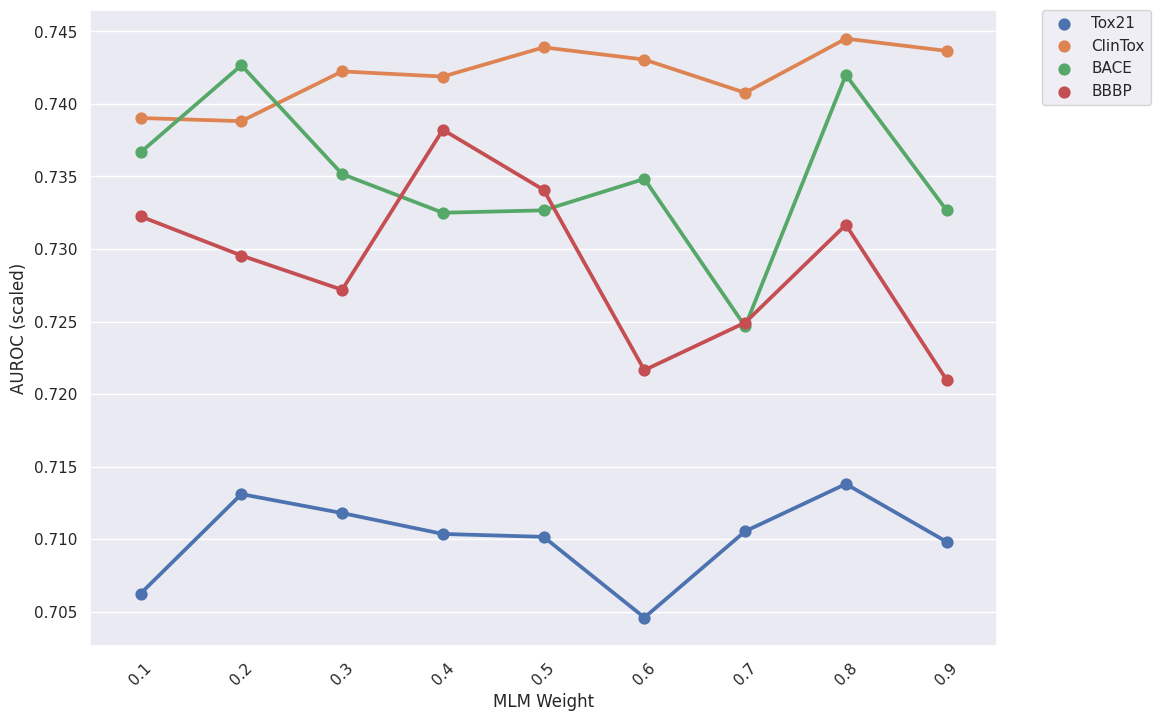

In [7]:
sns.set_style("darkgrid")
sns.set()
from matplotlib import pyplot as plt

a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=45)

#plt.yticks([x for x in np.arange(0.0, 1.0, 0.05)])
ax = sns.pointplot(
    data=df,
    x="MLM Weight", y="AUROC (scaled)", hue="dataset"
   # markers=True, dashes=False, err_style='bars'
);

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
"""
g = sns.FacetGrid(df, col="dataset", col_wrap=5)
g.map(sns.lineplot, "MLM Weight","AUROC")
plt.show()"""